In [14]:
import nltk
import os
from sklearn.utils import class_weight
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC
from collections import defaultdict
from collections import Counter
import itertools
import seaborn as sns
import math
start = time.time()
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_union
from scipy.sparse import hstack
import time
import regex as re
import string
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import gc
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  

In [45]:
!pyppeteer-install

[W:pyppeteer.chromium_downloader] start chromium download.
Download may take a few minutes.

100%|##########| 136913619/136913619 [00:24<00:00, 5643509.71it/s]
[W:pyppeteer.chromium_downloader] 
chromium download done.
[W:pyppeteer.chromium_downloader] chromium extracted to: C:\Users\shubh\AppData\Local\pyppeteer\pyppeteer\local-chromium\588429


In [15]:
data=pd.read_csv('C:\\Users\\shubh\\Documents\\Personal_work_stuff\\data_files\\CC_usecase1.csv')
data.columns=['Construction_description','Construction_code']
data=data[data['Construction_code']!='Unknown']
data['Construction_code']=data.Construction_code.astype('str')
data.Construction_code=data.Construction_code.convert_dtypes('categorical')
data=data.reset_index()
data=data.iloc[:,1:]

<AxesSubplot:>

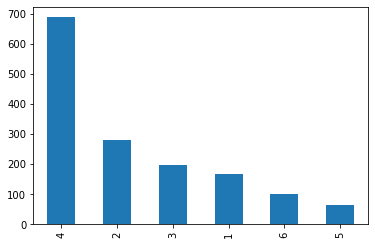

In [16]:
data['Construction_code'].value_counts().plot(kind="bar")

In [17]:
data['Construction_code'].value_counts()

4    688
2    282
3    197
1    168
6    101
5     65
Name: Construction_code, dtype: Int64

In [18]:
def cleaning(string):    
    string = str(string)
    string = string.lower()
    string = re.sub('\s\W',' ',string)
    string = re.sub('\W,\s',' ',string)
    string = re.sub(r'[^\w]', ' ', string)
    string = re.sub("\d+", "", string)
    string = re.sub('\s+',' ',string)
    string = re.sub('[!@#$_]', '', string)
    string = string.replace(",","")
    string = string.replace("[\w*"," ")
    string = re.sub(r'https?:\/\/.*[\r\n]*', '', string, flags=re.MULTILINE)
    string = re.sub(r'\<a href', ' ', string)
    string = re.sub(r'&amp;', '', string) 
    string = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', string)
    string = re.sub(r'[^\x00-\x7f]',r'',string) #removes arabic
    string = re.sub(r'<br />', ' ', string)
    string = re.sub(r'\'', ' ', string)
    string=string.lower()
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(string)  
    string = [w for w in word_tokens if not w in stop_words]

    string=' '.join(i for i in string)
    string=re.findall('[a-z]{1,}',string)
    string=' '.join(i for i in string)
    string=string.strip()
    return string

data.Construction_description = [cleaning(string) for string in data['Construction_description']]
        
     

In [19]:

char_vectorizer = TfidfVectorizer(analyzer='char_wb',sublinear_tf=True,strip_accents='unicode',token_pattern=r'\w{1,}',dtype=np.float32)
word_vectorizer = TfidfVectorizer(analyzer='word',sublinear_tf=True,strip_accents='unicode',dtype=np.float32)
tfidf = FeatureUnion([('char', char_vectorizer), ('word', word_vectorizer)])

def class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    weight = dict()
    for i in keys:
            score = np.log((mu)*(total)/float(labels_dict[i]))
            weight[i] = score if score > 1 else 1
    return weight

data['Construction_code']=data['Construction_code'].convert_dtypes('object')
labels_dict = data['Construction_code'].value_counts().to_dict()
weights = class_weight(labels_dict)
weights={'4': 1, '2': 1, '3': 1, '1': 1, '6': 1.1032320, '5': 1.2423795768519434}
pipeline = Pipeline([('tfidf', tfidf), ('clf', LinearSVC(class_weight=weights))])

In [20]:

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(data.Construction_description, data.Construction_code, train_size=0.70,random_state=0, stratify=data.Construction_code)


In [ ]:
pipeline.fit(X_train_tfidf,y_train_tfidf)
tf_params = {
 'tfidf__word__max_features':[200,500,700,900,1200],
 'tfidf__word__ngram_range': [(1, 1), (1, 2), (1,3),(1,4),(2,1),(2, 2)],
 'tfidf__word__stop_words': [None, 'english'],
 'tfidf__char__max_features':[100,300,500,700,900,1200,1500],
 'tfidf__char__ngram_range': [(1, 1), (1, 2), (1,3),(1,4),(2,1),(2, 2)],
 'tfidf__char__stop_words': [None, 'english'],
 'clf__C': [0.1, 1, 10, 100, 1000]
 
}


clf = GridSearchCV(pipeline, param_grid=tf_params, cv = 5, verbose = 1, n_jobs = -1)
clf.fit(X_train_tfidf, y_train_tfidf)
print(clf.best_params_)
print(clf.score(X_train_tfidf, y_train_tfidf))
print(clf.score(X_test_tfidf, y_test_tfidf))

In [ ]:
#Best parameter

In [22]:
{'clf__C': 1, 'tfidf__char__max_features': 500, 'tfidf__char__ngram_range': (1, 3), 'tfidf__char__stop_words': None, 'tfidf__word__max_features': 900, 'tfidf__word__ngram_range': (1, 4), 'tfidf__word__stop_words': None}

{'clf__C': 1,
 'tfidf__char__max_features': 500,
 'tfidf__char__ngram_range': (1, 3),
 'tfidf__char__stop_words': None,
 'tfidf__word__max_features': 900,
 'tfidf__word__ngram_range': (1, 4),
 'tfidf__word__stop_words': None}

In [23]:
pipeline.fit(X_train_tfidf,y_train_tfidf)
tf_params = {
 'tfidf__word__max_features':[900],
 'tfidf__word__ngram_range': [(1,4)],
 'tfidf__word__stop_words': [None, 'english'],
 'tfidf__char__max_features':[500],
 'tfidf__char__ngram_range': [((1,3))],
 'tfidf__char__stop_words': [None, 'english'],
 'clf__C': [1]
 
}


clf = GridSearchCV(pipeline, param_grid=tf_params, cv = 15, verbose = 1, n_jobs = -1)
clf.fit(X_train_tfidf, y_train_tfidf)
y_true, y_pred = y_test_tfidf, clf.predict(X_test_tfidf)
print(classification_report(y_true, y_pred))

Fitting 15 folds for each of 4 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s


              precision    recall  f1-score   support

           1       0.65      0.64      0.65        50
           2       0.84      0.67      0.75        85
           3       0.63      0.76      0.69        59
           4       0.86      0.90      0.88       207
           5       0.78      0.70      0.74        20
           6       0.93      0.87      0.90        30

    accuracy                           0.80       451
   macro avg       0.78      0.76      0.77       451
weighted avg       0.81      0.80      0.80       451



[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.7s finished


In [24]:
def implement_confidence_score(dfa,ypred,y_test,X_test,model):
    dfa=dfa.loc[y_test.index.tolist(),]
    dfa['pred']=ypred.tolist()
    conf=[]
    for arr in model.decision_function(X_test):
        conf.append(np.max(arr))
    dfa['conf']=conf
    return dfa

In [25]:
test_dfa=implement_confidence_score(data,y_pred,y_true,X_test_tfidf,clf)

In [26]:
classes=['1','2','3','4','5','6']
class_conf_range={}
for i in classes:
    class_conf_range[i]=(test_dfa[test_dfa['Construction_code']==i]['conf'])

class_conf_range_val={}
for i,j in class_conf_range.items():
    print("Min thresold of ",i,round(np.min(class_conf_range[i]),4)," and Max thresold of ",i,round(np.max(class_conf_range[i]),4))
    class_conf_range_val[i]=round(np.min(class_conf_range[i]),4)

Min thresold of  1 -0.5951  and Max thresold of  1 1.7348
Min thresold of  2 -0.5104  and Max thresold of  2 1.94
Min thresold of  3 -0.4002  and Max thresold of  3 1.1991
Min thresold of  4 -0.4548  and Max thresold of  4 2.0763
Min thresold of  5 -0.4008  and Max thresold of  5 1.5328
Min thresold of  6 -0.2514  and Max thresold of  6 1.572


In [27]:
def evaluate_nhi(df_test,classes_threshold):
    val_test=df_test

    def split_dfs(df,class_name):
        return df_test[df_test["Construction_code"]==class_name]

  


    df_test_1=split_dfs(df_test,"1")
    df_test_2=split_dfs(df_test,"2")
    df_test_3=split_dfs(df_test,"3")
    df_test_4=split_dfs(df_test,"4")
    df_test_5=split_dfs(df_test,"5")
    df_test_6=split_dfs(df_test,"6")


    def subset_acc_conf(df,threshold):
        return df[df['conf']>=threshold]

    one=classes_threshold[0]
    second=classes_threshold[1]
    third=classes_threshold[2]
    fourth=classes_threshold[3]
    fivth=classes_threshold[4]
    sixth=classes_threshold[5]
   
    df_test_filtered_0=subset_acc_conf(df_test_1,one)
    df_test_filtered_1=subset_acc_conf(df_test_2,second)
    df_test_filtered_2=subset_acc_conf(df_test_3,third)
    df_test_filtered_3=subset_acc_conf(df_test_4,fourth)
    df_test_filtered_4=subset_acc_conf(df_test_5,fivth)
    df_test_filtered_5=subset_acc_conf(df_test_6,sixth)

    df_test_filtered=pd.concat([df_test_filtered_0,df_test_filtered_1,df_test_filtered_2,df_test_filtered_3,df_test_filtered_4,df_test_filtered_5])
    
    print("NHI P",math.floor((val_test.shape[0]-df_test_filtered.shape[0])*100/val_test.shape[0]))
    cls=clf.classes_


    conf_mat = confusion_matrix(df_test_filtered['Construction_code'],  df_test_filtered['pred'])
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=cls, yticklabels=cls)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(metrics.classification_report(df_test_filtered['Construction_code'], df_test_filtered['pred']))


In [28]:

zero_threshold=[class_conf_range_val['1']+0.8459,class_conf_range_val['2']+0.09,
                class_conf_range_val['3'],class_conf_range_val['4'],
                class_conf_range_val['5']+0.001,class_conf_range_val['6']]


NHI P 5


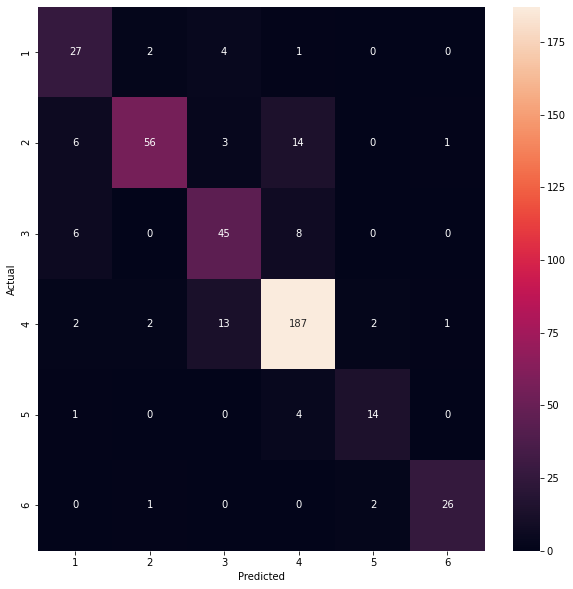

              precision    recall  f1-score   support

           1       0.64      0.79      0.71        34
           2       0.92      0.70      0.79        80
           3       0.69      0.76      0.73        59
           4       0.87      0.90      0.89       207
           5       0.78      0.74      0.76        19
           6       0.93      0.90      0.91        29

    accuracy                           0.83       428
   macro avg       0.81      0.80      0.80       428
weighted avg       0.84      0.83      0.83       428



In [29]:
evaluate_nhi(test_dfa,zero_threshold)

In [256]:
import pickle
def save_model(model_name,model,path):
    filename=model_name
    
    parent_path='C:\\Users\\shubh\\Documents\\Personal_work_stuff\\'

    os.chdir(parent_path+path)
    pickle.dump(model,open(filename,'wb'))
    os.chdir(parent_path)
    
    
def load_model(model_name,path):
    parent_path='C:\\Users\\shubh\\Documents\\Personal_work_stuff\\'
    os.chdir(parent_path+path)
    loaded_model = pickle.load(open(model_name, 'rb'))
    os.chdir(parent_path)
    return loaded_model



In [58]:
save_model("Construction_type",clf,"models")

In [38]:
all_vocab=[]

all_vocab_dict = defaultdict(list)

for i in range(0,len(data["Construction_description"])):
    all_vocab_dict[data.loc[i,'Construction_code']].append(data.loc[i,"Construction_description"].strip().split())
    

In [39]:

for i in all_vocab_dict.keys():
    all_vocab_dict[i]=list(itertools.chain.from_iterable(all_vocab_dict[i]))
    
    Counter_ = Counter(all_vocab_dict[i]) 
    most_occur = Counter_.most_common(10)
    print(most_occur)
    

[('wood', 98), ('frame', 76), ('stucco', 40), ('steel', 22), ('metal', 20), ('brick', 18), ('roof', 17), ('veneer', 13), ('walls', 10), ('exterior', 9)]
[('concrete', 361), ('steel', 315), ('masonry', 206), ('brick', 126), ('block', 124), ('metal', 115), ('frame', 103), ('deck', 65), ('reinforced', 55), ('slab', 53)]
[('fire', 61), ('concrete', 56), ('resistive', 50), ('reinforced', 17), ('frame', 14), ('poured', 14), ('fr', 10), ('steel', 10), ('precast', 9), ('roof', 8)]
[('wood', 123), ('brick', 93), ('masonry', 92), ('frame', 81), ('concrete', 80), ('block', 36), ('steel', 26), ('slab', 24), ('jm', 22), ('joisted', 20)]
[('steel', 105), ('metal', 81), ('frame', 66), ('concrete', 28), ('non', 26), ('exterior', 25), ('glass', 18), ('roof', 17), ('stucco', 16), ('slab', 14)]
[('fire', 29), ('modified', 27), ('steel', 24), ('resistive', 24), ('concrete', 17), ('mod', 16), ('structural', 14), ('fr', 12), ('frame', 6), ('reinforced', 4)]


In [36]:
(set(list(set(all_vocab_dict['1']).union(all_vocab_dict['2'], all_vocab_dict['3'], all_vocab_dict['4'],all_vocab_dict['5'],all_vocab_dict['6'])) ))

{'accounting',
 'ade',
 'adobe',
 'aerated',
 'aggregate',
 'aid',
 'alarm',
 'also',
 'alum',
 'aluminium',
 'aluminum',
 'ans',
 'appearance',
 'approved',
 'apt',
 'apts',
 'arch',
 'arched',
 'areas',
 'around',
 'asbestos',
 'asphalt',
 'assembly',
 'atexterior',
 'attachments',
 'autoclaved',
 'automatic',
 'b',
 'back',
 'ballast',
 'ballasted',
 'band',
 'bar',
 'barrel',
 'base',
 'basement',
 'bay',
 'bc',
 'beam',
 'beams',
 'bearing',
 'beems',
 'beyond',
 'big',
 'bit',
 'bitumen',
 'bitumin',
 'bk',
 'bl',
 'black',
 'bldg',
 'blick',
 'blk',
 'block',
 'blocked',
 'blocks',
 'blockwall',
 'board',
 'boards',
 'boca',
 'br',
 'braced',
 'brick',
 'bricks',
 'brickwall',
 'brickwalls',
 'brock',
 'build',
 'buildg',
 'building',
 'buildings',
 'built',
 'builtup',
 'bur',
 'c',
 'cable',
 'canopy',
 'cas',
 'cast',
 'cb',
 'cbs',
 'ceiling',
 'ceilings',
 'cement',
 'center',
 'certified',
 'cinder',
 'cinderblock',
 'circulation',
 'clad',
 'cladding',
 'clapboard',
 'cla

In [33]:
len(list(set(all_vocab_dict['1']).intersection(all_vocab_dict['2'], all_vocab_dict['3'], all_vocab_dict['4'],all_vocab_dict['5'],all_vocab_dict['6'])) )

17

In [34]:
(list(set(all_vocab_dict['1']).intersection(all_vocab_dict['2'], all_vocab_dict['3'], all_vocab_dict['4'],all_vocab_dict['5'],all_vocab_dict['6'])) )

['stone',
 'roof',
 'columns',
 'deck',
 'w',
 'veneer',
 'frame',
 'protected',
 'structure',
 'concrete',
 'office',
 'iso',
 'combustible',
 'brick',
 'steel',
 'masonry',
 'tilt']